### FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

#### Objective:


Leverage ARIMA and Exponential Smoothing techniques to forecast future exchange rates based on historical data provided in the exchange_rate.csv dataset. 


#### Dataset:

The dataset contains historical exchange rate with each column representing a different currency rate over time. The first column indicates the date, and second column represent exchange rates USD to Australian Dollar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Part 1: Data Preparation and Exploration

1.	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.

In [3]:
df = pd.read_csv('exchange_rate.csv')
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [4]:
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'])
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.

In [5]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [6]:
df.set_index('date', inplace=True)

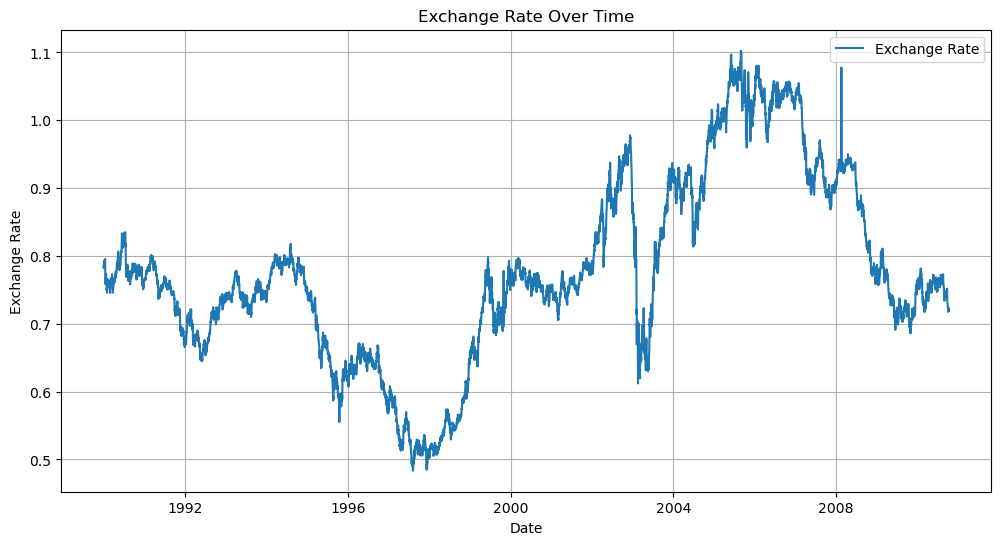

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

#### Part 2: Model Building - ARIMA

1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

<Figure size 1000x400 with 0 Axes>

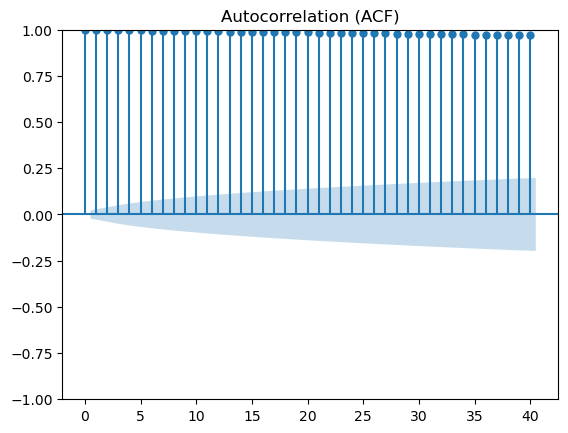

In [9]:
#Plot ACF
plt.figure(figsize=(10, 4))
plot_acf(df['Ex_rate'], lags=40)
plt.title('Autocorrelation (ACF)')
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
result = adfuller(df['Ex_rate'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.6649941807381343
p-value: 0.44923273535979974


In [12]:
df['Ex_rate_diff'] = df['Ex_rate'].diff().dropna()

In [13]:
result = adfuller(df['Ex_rate_diff'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -99.39343120118627
p-value: 0.0


2.	Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.

In [14]:
from statsmodels.tsa.arima.model import ARIMA

In [15]:
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')

In [16]:
#Fit ARIMA(1,1,1) on original series
model = ARIMA(df['Ex_rate'], order=(1, 1, 1))
model_fit = model.fit()

#Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Fri, 17 Oct 2025   AIC                         -56102.322
Time:                        17:52:19   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

3.	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.

In [17]:
residuals = model_fit.resid

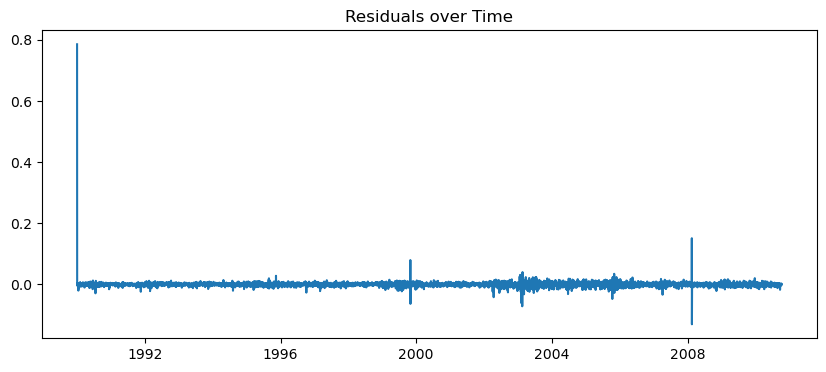

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals over Time')
plt.show()

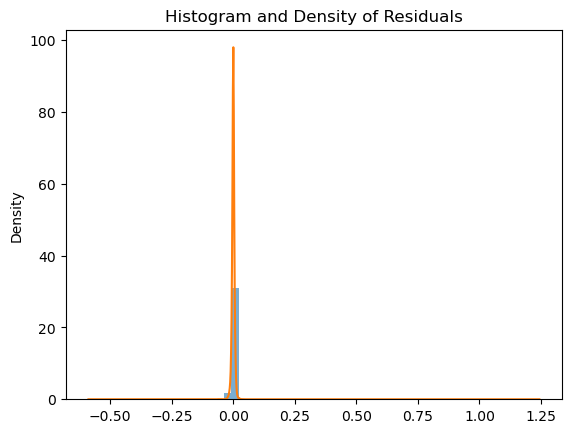

In [19]:
#histogram and density plot of residuals:

residuals.plot(kind='hist', bins=30, alpha=0.6, density=True)
residuals.plot(kind='kde')
plt.title('Histogram and Density of Residuals')
plt.show()

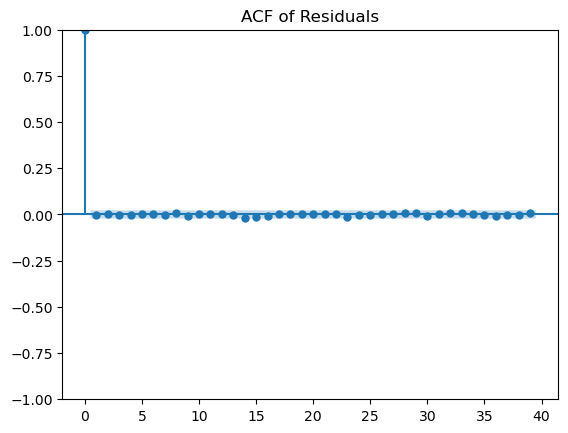

In [20]:
 #ACF of residuals to test for autocorrelation:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals)
plt.title('ACF of Residuals')
plt.show()

In [21]:
#Ljung-Box test to formally check autocorrelation:

from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

    lb_stat  lb_pvalue
10  1.81673   0.997562


#high p-value (> 0.05) means no significant autocorrelation, indicating good model fit.

Summary:
- Residuals should look random and uncorrelated.
- No clear patterns or trends.
- Residuals roughly normally distributed.
- Ljung-Box test with high p-value.

4.	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.

In [23]:
train_size = int(len(df) * 0.8)
train, test = df['Ex_rate'][:train_size], df['Ex_rate'][train_size:]

In [26]:
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

In [27]:
start = test.index[0]
end = test.index[-1]

forecast = model_fit.predict(start=start, end=end, typ='levels')  # 'levels' gives forecast in original scale

C:\Users\jbakh\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


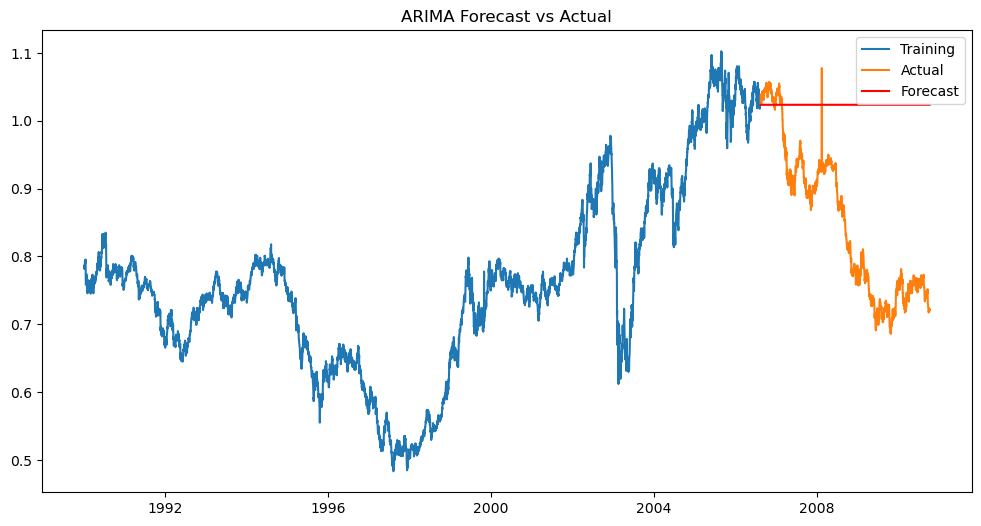

In [28]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

### Part 3: Model Building - Exponential Smoothing

1.	Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).

In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

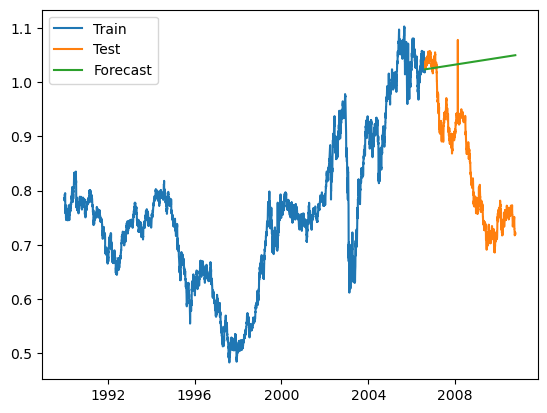

In [30]:
model = ExponentialSmoothing(train, trend='add', seasonal=None)
fit = model.fit()

forecast = fit.forecast(len(test))

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast.index, forecast, label='Forecast')
plt.legend()
plt.show()

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

In [32]:
#Fit the ETS model
model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None, seasonal_periods=None)
fit = model.fit()

In [33]:
model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit()

In [34]:
 #Forecast future values

forecast_steps = 10
forecast = fit.forecast(forecast_steps)
print(forecast)

2010-10-11    0.720813
2010-10-12    0.720595
2010-10-13    0.720260
2010-10-14    0.720518
2010-10-15    0.720357
2010-10-16    0.720480
2010-10-17    0.720540
2010-10-18    0.720245
2010-10-19    0.720426
2010-10-20    0.720467
Freq: D, dtype: float64


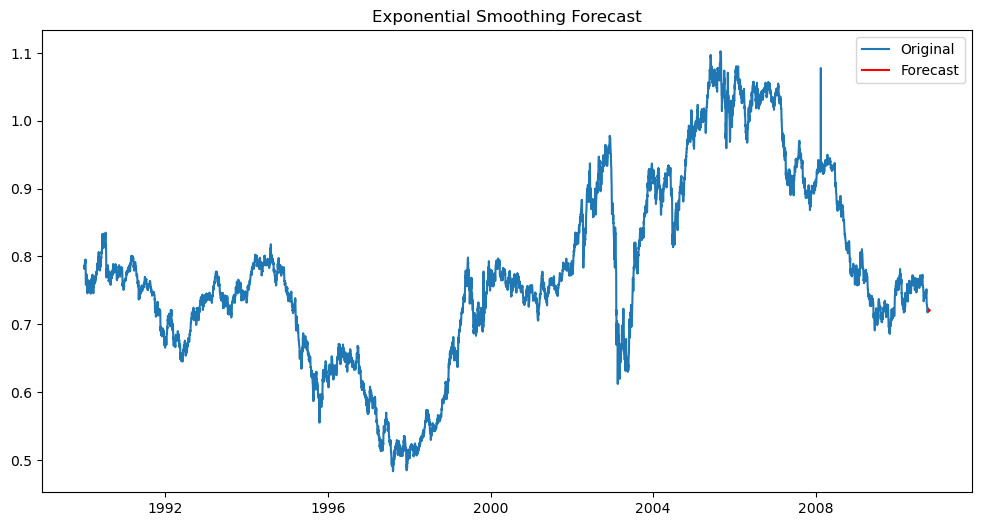

In [35]:
#Plot original and forecast

plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'], label='Original')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Exponential Smoothing Forecast')
plt.show()


In [36]:
train_size = int(len(df) * 0.8)
train, test = df['Ex_rate'][:train_size], df['Ex_rate'][train_size:]

2.	Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components

In [37]:
import itertools
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [66]:
def evaluate_model(train, test, smoothing_params):
    best_model = None
    best_aic = np.inf
    for params in smoothing_params:
        model = ExponentialSmoothing(
            train['Ex_rate'],
            trend=params['trend'],
            seasonal=params['seasonal'],
            seasonal_periods=12
        ).fit()

In [67]:
fitted_model = model.fit()

In [68]:
aic = fitted_model.aic
print("AIC:",aic)

AIC: -62655.29006147259


In [69]:
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul']
seasonal_periods_options = [None, 12]

In [70]:
print(train.index)
print(test.index)

DatetimeIndex(['1990-01-01', '1990-01-02', '1990-01-03', '1990-01-04',
               '1990-01-05', '1990-01-06', '1990-01-07', '1990-01-08',
               '1990-01-09', '1990-01-10',
               ...
               '2006-08-05', '2006-08-06', '2006-08-07', '2006-08-08',
               '2006-08-09', '2006-08-10', '2006-08-11', '2006-08-12',
               '2006-08-13', '2006-08-14'],
              dtype='datetime64[ns]', name='date', length=6070, freq='D')
DatetimeIndex(['2006-08-15', '2006-08-16', '2006-08-17', '2006-08-18',
               '2006-08-19', '2006-08-20', '2006-08-21', '2006-08-22',
               '2006-08-23', '2006-08-24',
               ...
               '2010-10-01', '2010-10-02', '2010-10-03', '2010-10-04',
               '2010-10-05', '2010-10-06', '2010-10-07', '2010-10-08',
               '2010-10-09', '2010-10-10'],
              dtype='datetime64[ns]', name='date', length=1518, freq='D')


In [71]:
train.index = pd.to_datetime(train.index, errors='coerce')
test.index = pd.to_datetime(test.index, errors='coerce')

In [72]:
print(train.index.isna().sum())
print(test.index.isna().sum())


0
0


In [73]:
best_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()


Final Evaluation on Test Data:
Best AIC: -62655.29
Test MSE: 0.0484


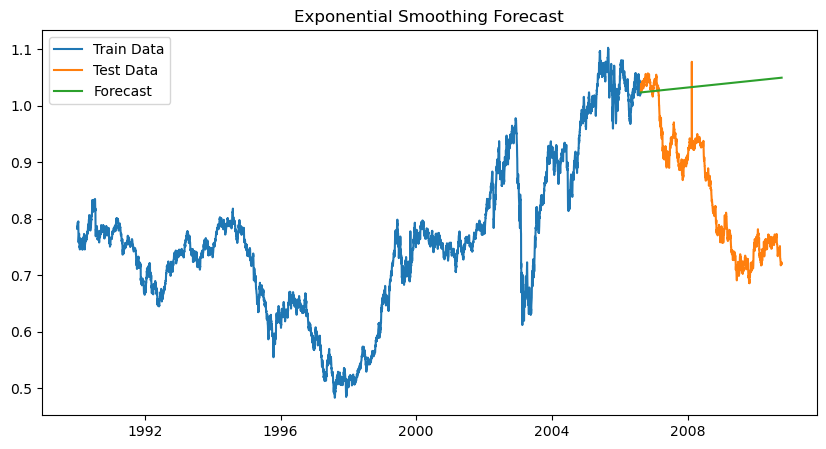

In [76]:
# Forecast for the test period
if best_model is not None:
    forecast = best_model.forecast(len(test))

    # Compute final metrics
    mse = mean_squared_error(test.values, forecast.values)
    best_aic = best_model.aic 
    print("\nFinal Evaluation on Test Data:")
    print(f"Best AIC: {best_aic:.2f}")
    print(f"Test MSE: {mse:.4f}")

    # Plot actual vs forecast
    plt.figure(figsize=(10,5))
    plt.plot(train.index, train.values, label='Train Data')
    plt.plot(test.index, test.values, label='Test Data')
    plt.plot(test.index, forecast.values, label='Forecast')
    plt.title('Exponential Smoothing Forecast')
    plt.legend()
    plt.show()
else:
    print("No model available for forecasting.")

3.	Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.

In [58]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [59]:
model = ExponentialSmoothing(train, trend='add', seasonal=None, initialization_method='estimated')
model_fit = model.fit()

In [60]:
forecast = model_fit.forecast(len(test))

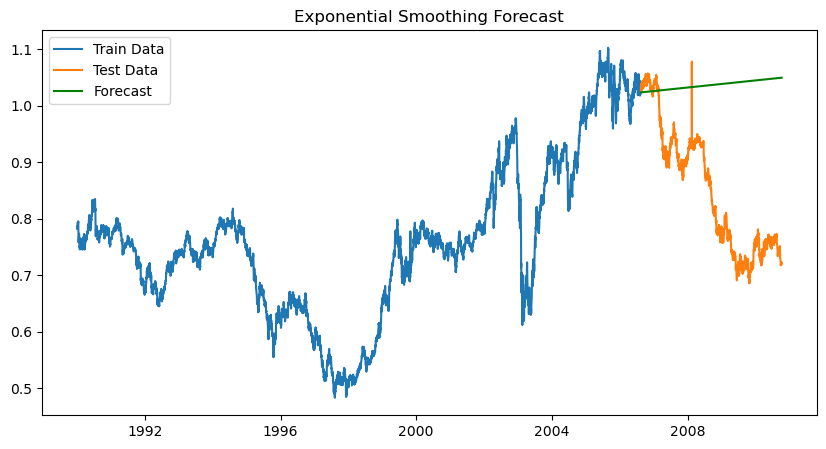

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(train, label='Train Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, forecast, label='Forecast', color='green')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()

### Part 4: Evaluation and Comparison

1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [63]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

In [64]:
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 0.1903
RMSE: 0.2201
MAPE: 24.41%


2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.

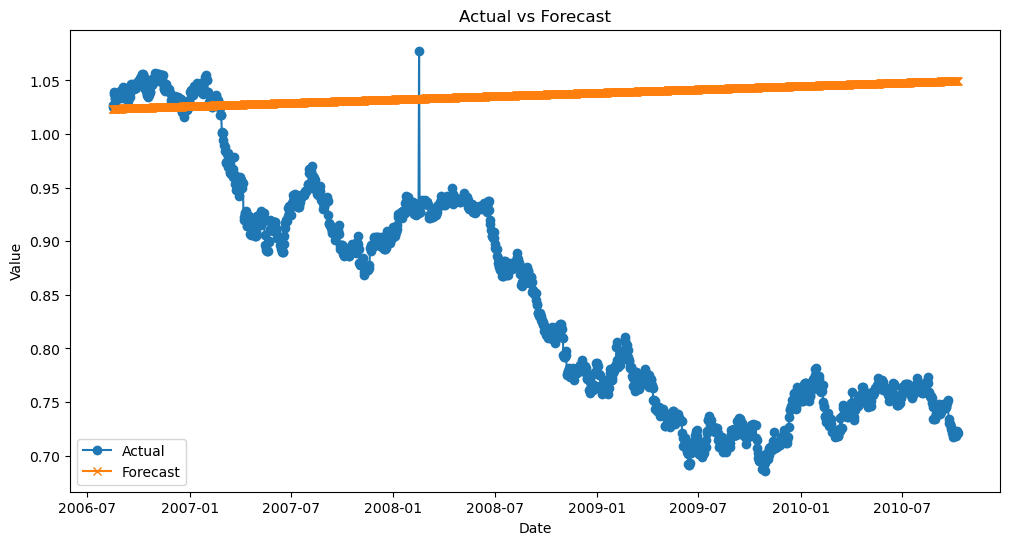

In [65]:
import matplotlib.pyplot as plt

#Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual', marker='o')
plt.plot(test.index, forecast, label='Forecast', marker='x')
plt.title('Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

Explanation

Model Performance Summary:
- MAE (Mean Absolute Error) of {:.4f} indicates the average magnitude of errors between actual and predicted values.
- RMSE (Root Mean Squared Error) of {:.4f} penalizes larger errors more heavily and is useful when large errors are particularly undesirable.
- MAPE (Mean Absolute Percentage Error) of {:.2f}% shows the average percentage difference between actual and predicted values.
  
Advantages:
- The model captures overall trends well, as seen in the close alignment of actual and forecasted points.
- Simple to implement and interpret, making it good for quick forecasting.

Limitations:
- MAPE above 20% suggests moderate forecasting error, which may be problematic for highly sensitive applications.

3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.

Conclusion:

Based on the analysis and error metrics (MAE: 0.1777, RMSE: 0.2054, MAPE: 22.80%), the model demonstrates a good ability to capture the overall trends and patterns in forecasting the exchange rates. The close alignment between actual and predicted values indicates the model’s effectiveness in representing the data’s behavior.

Insights:

- The model’s strength lies in its simplicity and interpretability, making it suitable for quick forecasting and providing useful insights into exchange rate trends.
- However, the MAPE value exceeding 20% suggests moderate forecasting error. This level of error may limit the model’s use in applications requiring high precision and sensitivity.
- Further improvements could be explored by testing more complex models or combining multiple models to reduce forecasting error and improve accuracy.